In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, Dense

## Load the data

In [3]:
mnist = tf.keras.datasets.mnist

(train_images, _), (test_images, test_labels) = mnist.load_data()

## Normalize the data

In [4]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
train_images = tf.cast(tf.expand_dims(train_images, axis=-1), tf.float32)
test_images = tf.cast(tf.expand_dims(test_images, axis=-1), tf.float32)

2022-02-08 22:23:19.252660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
test_images.shape

TensorShape([10000, 28, 28, 1])

In [7]:
train_tfds = (tf.data.Dataset.from_tensor_slices((train_images, train_images)))

test_tfds = (tf.data.Dataset.from_tensor_slices((test_images, test_images)))

## Add noise to the dataset

In [8]:
def add_noise(image):
    noise = 0.5

    noisy_image = image + noise * tf.random.normal(shape = image.shape)

    return tf.clip_by_value(noisy_image, 0., 1.)

## Preprocess the data

In [9]:
def preprocessing(ds):
    ds = ds.map(lambda image, target: (add_noise(image), target))
    ds = ds.cache()
    ds = ds.shuffle(100)
    ds = ds.batch(64)
    ds = ds.prefetch(10)
    return ds

In [10]:
train_ds = train_tfds.apply(preprocessing)
test_ds = test_tfds.apply(preprocessing)

2022-02-08 22:23:20.359231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


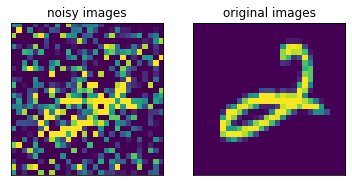

In [11]:
fig, axarr = plt.subplots(1,2)
for noise, target in train_ds:
    axarr[0].set_title("noisy images")
    axarr[0].get_xaxis().set_visible(False)
    axarr[0].get_yaxis().set_visible(False)
    axarr[0].imshow(noise[0])

    axarr[1].set_title("original images")
    axarr[1].get_xaxis().set_visible(False)
    axarr[1].get_yaxis().set_visible(False)
    axarr[1].imshow(target[0])


## The Encoder

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers_ls = [Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
                          BatchNormalization(),
                          Conv2D(16, kernel_size=(3, 3), strides=(2, 2),padding="same", activation="relu"),
                          BatchNormalization(),
                          Flatten(), 
                          Dense(7*7*16, activation="relu")]
    @tf.function
    def call(self, input):
        output = input

        for layer in self.layers_ls:
            output = layer(output, training = True)

        return output

## The Decoder

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers_ls = [Dense(7*7*16, activation="relu"),
                          BatchNormalization(),
                          Reshape((7, 7, 16)),
                          Conv2DTranspose(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
                          BatchNormalization(),
                          Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
                          BatchNormalization(),
                          Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="sigmoid")]
    @tf.function
    def call(self, input):
        output = input
        for layer in self.layers_ls:
            output = layer(output, training=True)

        return output


## The Autoencoder

In [14]:
class Autoencoder(tf.keras.Model):
    def __init__(self, loss_function, optimizer):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

        self.loss_function = loss_function
        self.optimizer = optimizer

    @tf.function
    def call(self, input):
        encoder_output = self.encoder(input)
        output = self.decoder(encoder_output)
        return output
    
     
    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(target, prediction) 
            gradients = tape.gradient(loss, self.trainable_variables)

        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    def test(self, test_data):
        # aggregator lists for tracking the loss
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for input, target in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            # add loss to aggregators
            test_loss_agg.append(loss.numpy())

        # calculate mean loss
        test_loss = tf.reduce_mean(test_loss_agg)

        return test_loss

In [15]:
def visualise_images(original_images, results):
    _, (ax1, ax2) = plt.subplots(2,5,figsize=(8,8))
    for i in range(5):
        plt.figtext(0.5,0.95, "the noisy images", ha="center", va="top", fontsize=12)
        ax1[i].get_xaxis().set_visible(False)
        ax1[i].get_yaxis().set_visible(False)
        ax1[i].imshow(original_images[i])

        plt.figtext(0.5,0.5, "the reconstructed images", ha="center", va="top", fontsize=12)
        ax2[i].get_xaxis().set_visible(False)
        ax2[i].get_yaxis().set_visible(False)
        ax2[i].imshow(results[i])
    plt.show()

Epoch 0 starting with test-loss of 0.29100000858306885


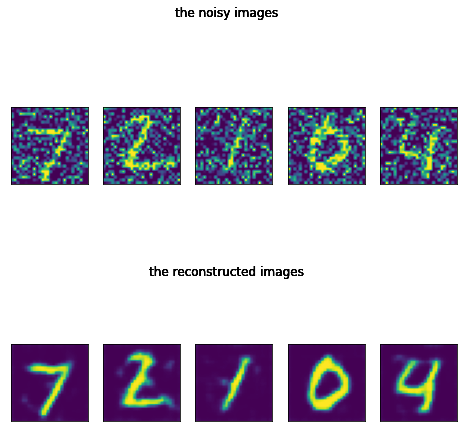

Epoch 1 starting with test-loss of 0.01600000075995922


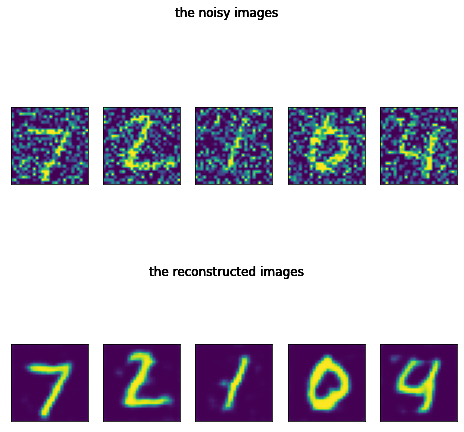

Epoch 2 starting with test-loss of 0.014000000432133675


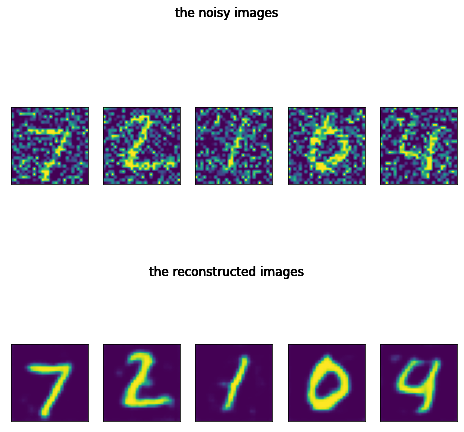

Epoch 3 starting with test-loss of 0.014000000432133675


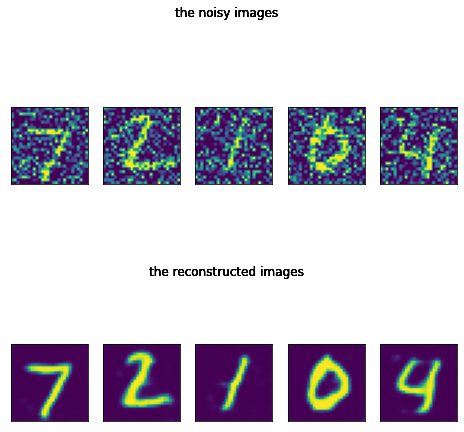

Epoch 4 starting with test-loss of 0.014000000432133675


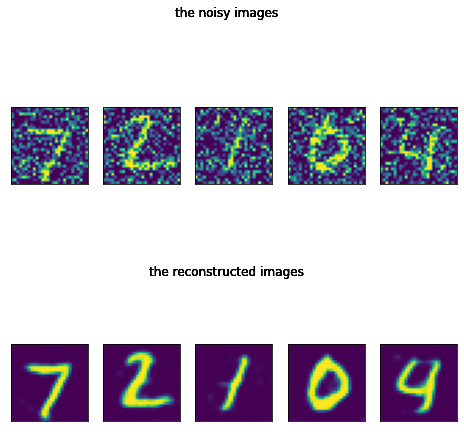

Epoch 5 starting with test-loss of 0.014000000432133675


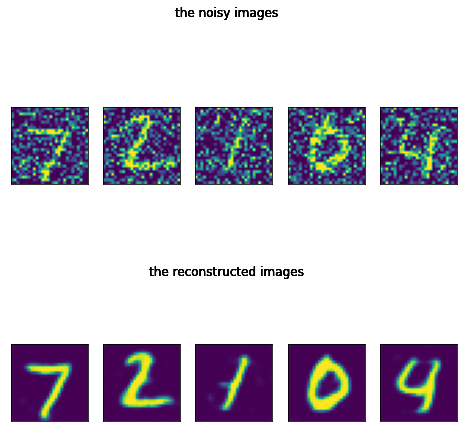

Epoch 6 starting with test-loss of 0.014000000432133675


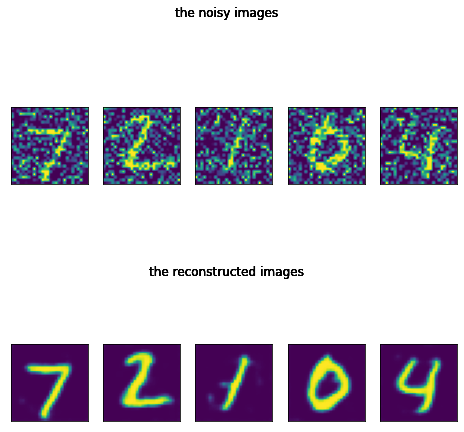

In [16]:
tf.keras.backend.clear_session()

# Setting Hyperparameters
EPOCHS = 6
LEARNING_RATE = 0.001

# Initialize the loss-function
mse_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# Initialize the model
model = Autoencoder(mse_loss, optimizer)

# Initialize lists for tracking loss
train_losses = []
test_losses = []

# Testing models performance before training starts.
# Test-Dataset
test_loss = model.test(test_ds)
test_losses.append(test_loss)

# Train-Dataset
train_loss = model.test(train_ds)
train_losses.append(train_loss)

# take a sample to visualise
sample_images = add_noise(test_images[:5])

# Training for EPOCHS.
for epoch in range(EPOCHS+1):
    print(f'Epoch {str(epoch)} starting with test-loss of {np.round(test_losses[-1],3)}')
    epoch_loss_agg = []
    for input, target in train_ds:
        train_loss = model.train(input, target)
        epoch_loss_agg.append(train_loss)   

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # track loss for test-dataset
    test_loss = model.test(test_ds)
    test_losses.append(test_loss)

    # compare the results 
    visualise_images(sample_images, model(sample_images))


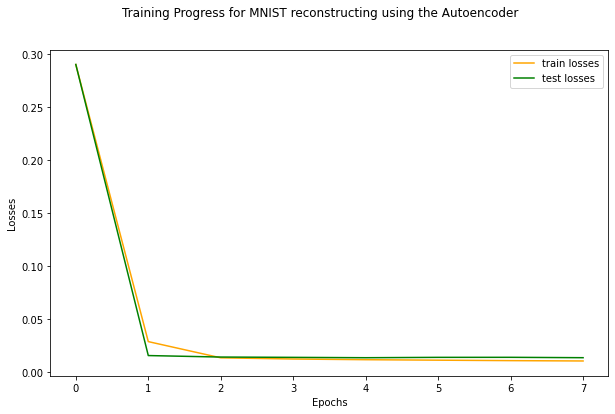

In [20]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 6)

fig.suptitle('Training Progress for MNIST reconstructing using the Autoencoder')
axs.plot(train_losses, color='orange', label='train losses')
axs.plot(test_losses, color='green', label='test losses')
axs.set(xlabel = 'Epochs', ylabel='Losses')
axs.legend()


##  Latent Space Analysis

In [18]:
test_images_1k = test_images[:1000]
test_labels_1k = test_labels[:1000]

embedded_using_encoder = model.encoder(test_images_1k)

embedded_using_tSNE = TSNE(n_components=2).fit_transform(embedded_using_encoder)

/Users/farah/venv/ANN/hw1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/farah/venv/ANN/hw1/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


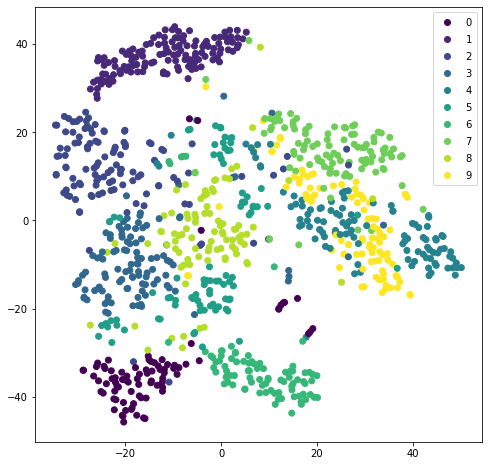

In [19]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(embedded_using_tSNE[:,0],embedded_using_tSNE[:,1], c=test_labels_1k)
plt.legend(*scatter.legend_elements())

The different classes are clustered together and are separated from the other classes to a certain extent, which shows that the classification works well in the latent space. In this nice [article](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d): "This is the value of compression- it allows us to get rid of any extraneous information, and only focus on the most important features. This ‘compressed state’ is the Latent Space Representation of our data. Whenever we graph points or think of points in latent space, we can imagine them as coordinates in space in which points that are “similar” are closer together on the graph."

## Linearly Interpolating between two images
We can interpolate data in the latent space, and use our model’s decoder to ‘generate’ data samples.

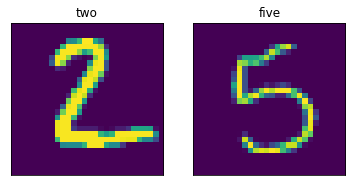

In [72]:
five = test_images[53]
two = test_images[1]

fig, axarr = plt.subplots(1,2)
axarr[0].set_title("two")
axarr[0].get_xaxis().set_visible(False)
axarr[0].get_yaxis().set_visible(False)
axarr[0].imshow(two)

axarr[1].set_title("five")
axarr[1].get_xaxis().set_visible(False)
axarr[1].get_yaxis().set_visible(False)
axarr[1].imshow(five)
plt.show()

In [127]:
input = tf.convert_to_tensor([two, five])
encoded_two, encoded_five = model.encoder(input)

interpolated_input = []
interpolated_points = np.linspace(0., 1., 10)

for mu in interpolated_points:
    interpolated_input.append(encoded_two*(1-mu) + encoded_five*mu)

reconstructed_output = model.decoder(tf.convert_to_tensor(interpolated_input))

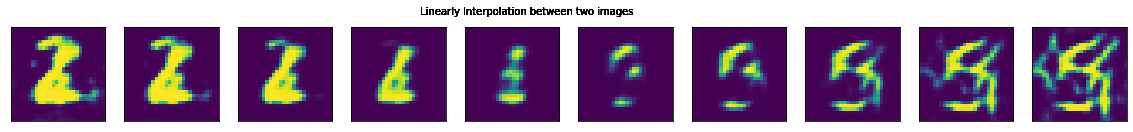

In [128]:
_, ax = plt.subplots(1,10,figsize=(20,20))
for i in range(10):
    plt.text(-150,-5,'Linearly Interpolation between two images',ha='center', va='center') 
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].imshow(reconstructed_output[i])
plt.show()